In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pymysql
import numpy as np
import pickle
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')

In [31]:
import os
def pickleLoad(file):
    if os.path.isfile(file):        
        with open(file,"rb") as fr:
            dataframe = pickle.load(fr)
        return dataframe
    else:  
        %run -i 'getTrainTestSet.py' 

In [32]:
# load train, test set data

X_train = pickleLoad('./dataset/X_train.pkl')
X_test = pickleLoad('./dataset/X_test.pkl')
y_train = pickleLoad('./dataset/y_train.pkl')
y_test = pickleLoad('./dataset/y_test.pkl')
ccsi = pickleLoad('./dataset/ccsi.pkl')
predictors = pickleLoad('./dataset/predictors.pkl')

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step3. Modeling
### model 2. ridge linear regression

* model fitting

In [34]:
# grid search를 해서, 최적의 파라미터를 갖는 트리 모델을 적합
param_grid = { 'alpha' : [10, 0.1, 0.01, 0.001]}

model_ridge = GridSearchCV( Ridge(), param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

model_ridge.fit(X_train_scaled, y_train)
model_ridge.best_params_

{'alpha': 0.1}

In [35]:
y_pred = model_ridge.predict(X_test_scaled) # y_pred: test set을 넣어서 얻은 예측 값
y_pred

array([[ 96.11727434],
       [108.06620893],
       [ 95.47572171],
       [109.65915871],
       [ 92.1796831 ],
       [104.46404319],
       [ 93.72088902],
       [102.24213594],
       [101.32528533],
       [ 95.89124531],
       [103.40386917],
       [111.83050383]])

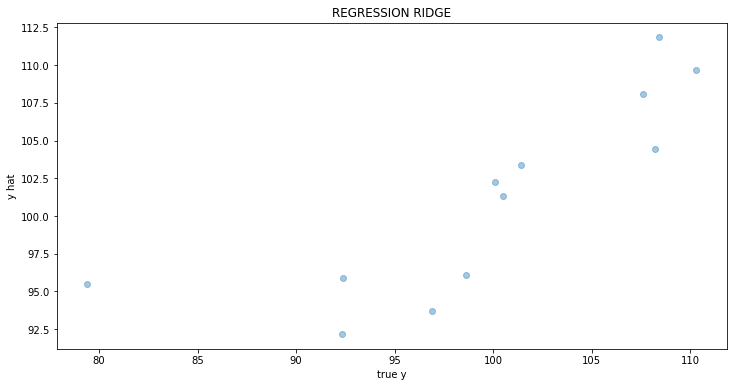

In [36]:
# test set에 대한 실제값과 예측 값의 추세 확인
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("true y")
plt.ylabel("y hat")
plt.title("REGRESSION RIDGE")
plt.show()

In [37]:
print("training RMSE: ", np.sqrt(-model_ridge.best_score_)) 
print("test RMSE: ", np.sqrt(-model_ridge.score(X_test_scaled, y_test)))

training RMSE:  3.847976499763832
test RMSE:  5.1844468037983


## Step4. Validate

여러 모델들을 활용하여, validating 하는 단계

## Step5. Visualization
### weekly record 예측하기(weekly CCSI)

In [38]:
# weekly 레코드들을 예측 모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi = model_ridge.predict(scaler.transform(predictors[['keyword1','keyword2','keyword3','keyword4','keyword5','google','naver']]))

In [39]:
tmp = pd.merge(predictors, ccsi).drop(['id'], axis=1)
tmp['pred'] = pred_ccsi
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred
0,2016,1,4,825,419,437,986,168,53.0,26.05846,99.5,103.881731
1,2016,1,11,770,348,351,626,182,58.0,25.16599,99.5,100.836281
2,2016,1,18,918,422,441,445,147,74.0,27.38639,99.5,93.836695
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,99.5,89.495919
4,2016,2,1,899,341,485,289,110,63.0,23.01888,97.2,93.957429


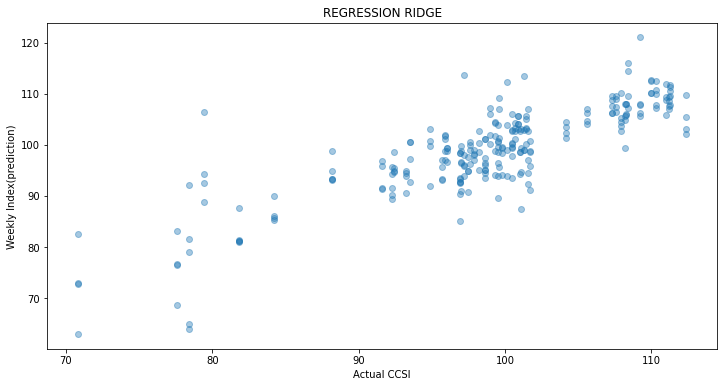

In [40]:
# true와 pred의 추세 확인
plt.scatter(tmp['ccsi'], tmp['pred'], alpha=0.4)
plt.xlabel("Actual CCSI")
plt.ylabel("Weekly Index(prediction)")
plt.title("REGRESSION RIDGE")
plt.show()

In [41]:
# weekly별 단기지표 값에 대한 MSE
print("MSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred'])))

MSE about weekly CCSI:  5.057388364403248


### visualization
* 시계열 그래프

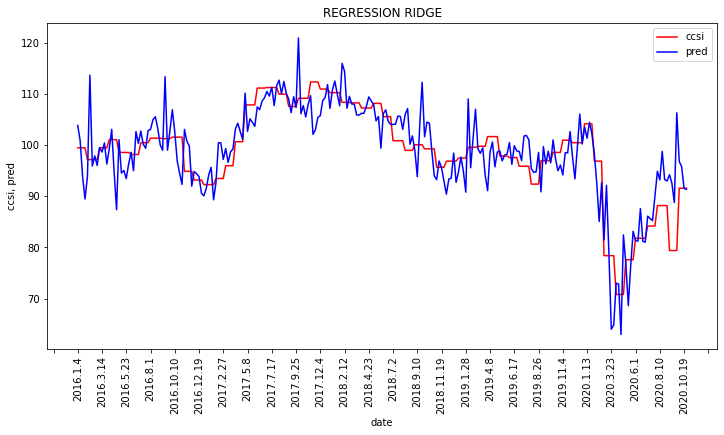

In [42]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("REGRESSION RIDGE")
plt.legend()
plt.show()

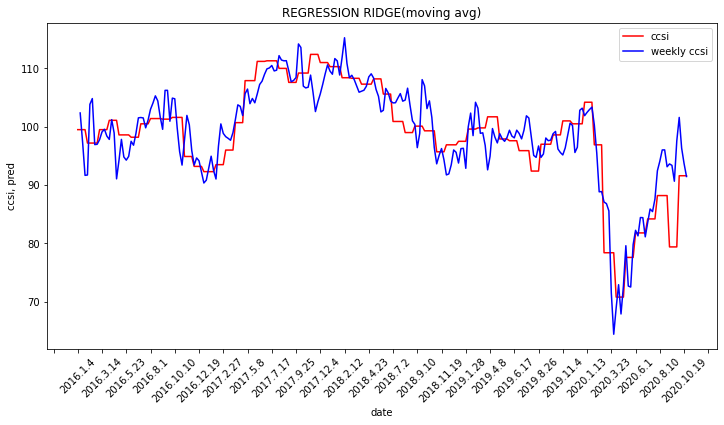

In [43]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("REGRESSION RIDGE(moving avg)")
plt.legend()
plt.show()